<a href="https://colab.research.google.com/github/tommyEzreal/study_low_level/blob/main/pytorch/%EB%AA%A8%EB%91%90%EB%A5%BC%EC%9C%84%ED%95%9C%EB%94%A5%EB%9F%AC%EB%8B%9D2/Batch_Noramlization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# gradient vanishing and exploding 

# 1.  Change activation function
# 2. Careful initialization (weight) - He / Xavier initialization
# 3. Small learning rate
# 4. Batch Normalization  

In [2]:
import torch
import torchvision.datasets as dsets 
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [3]:
# covariate shift - change of dist 
# normalize each mini batch of train data

batch_norm = torch.nn.BatchNorm1d(32)

bn_model = torch.nn.Linear(784, 32, bias=True)

In [4]:
bn_model

Linear(in_features=784, out_features=32, bias=True)

batch-norm 성능비교

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(0)
if device == 'cuda':
    torch.cuda.manual_seed_all(0)

In [6]:
# parameters
learning_rate = 0.01
epochs = 10
batch_size = 32

In [7]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [8]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [9]:
# layers 

# with batch norm
linear1 = torch.nn.Linear(784,32, bias=True)
linear2 = torch.nn.Linear(32,32, bias=True)
linear3 = torch.nn.Linear(32,10, bias=True)

relu = torch.nn.ReLU()

batch_norm_1 = torch.nn.BatchNorm1d(32)
batch_norm_2 = torch.nn.BatchNorm1d(32)

# without batch norm 
nn_linear1 = torch.nn.Linear(784,32,bias=True)
nn_linear2 = torch.nn.Linear(32,32,bias=True)
nn_linear3 = torch.nn.Linear(32,10,bias=True)

In [10]:
# model 

bn_model = torch.nn.Sequential(linear1, batch_norm_1, relu,
                               linear2, batch_norm_2, relu,
                               linear3).to(device)


nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)
                                                        

In [11]:
# loss func
criterion = torch.nn.CrossEntropyLoss().to(device)

# optimizer 
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [12]:
from tqdm.auto import tqdm 

# train/test loss&acc each 
# 두개의 모델을 하나의 loop에서 동시학습 
train_cost = []
train_acc = []

val_cost = []
val_acc = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)

# train loop

for epoch in tqdm(range(epochs+1)):
  bn_model.train() #train phase

  for X,Y in train_loader:
    X = X.view(-1,784).to(device)
    Y = Y.to(device)

    # bn model
    bn_pred = bn_model(X)
    bn_cost = criterion(bn_pred, Y)
    
    bn_optimizer.zero_grad()
    bn_cost.backward()
    bn_optimizer.step()


    # nn model
    nn_pred = nn_model(X)
    nn_cost = criterion(nn_pred, Y)


    nn_optimizer.zero_grad()
    nn_cost.backward()
    nn_optimizer.step()

  # evaluation in each batch  
  with torch.no_grad():
    bn_model.eval() # eval phase 

    bn_cost, nn_cost, bn_acc, nn_acc = 0,0,0,0

    for i, (X,Y) in enumerate(train_loader):
      X = X.view(-1,784).to(device)
      Y = Y.to(device)

      # bn eval 
      bn_pred = bn_model(X)
      bn_cost += criterion(bn_pred, Y)
      bn_correct_pred = torch.argmax(bn_pred,1) == Y
      bn_acc += bn_correct_pred.float().mean()

      #nn eval 
      nn_pred = nn_model(X)
      nn_cost += criterion(nn_pred, Y)
      nn_correct_pred = torch.argmax(nn_pred,1) == Y
      nn_acc += nn_correct_pred.float().mean()     

    bn_cost = bn_cost / train_total_batch 
    nn_cost = nn_cost / train_total_batch
    bn_acc = bn_acc / train_total_batch
    nn_acc = nn_acc / train_total_batch

    # save train cost 
    train_cost.append([bn_cost, nn_cost])
    train_acc.append([bn_acc, nn_acc])
    print('[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_cost:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_cost:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_cost.item(), bn_acc.item(), nn_cost.item(), nn_acc.item()))
    









  0%|          | 0/11 [00:00<?, ?it/s]

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_cost:0.12354(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_cost:0.17258(nn_acc:0.95)
[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_cost:0.09707(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_cost:0.16219(nn_acc:0.95)
[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_cost:0.08830(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_cost:0.15731(nn_acc:0.96)
[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_cost:0.07265(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_cost:0.14684(nn_acc:0.96)
[Epoch 5-TRAIN] Batchnorm Loss(Acc): bn_cost:0.06846(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_cost:0.15662(nn_acc:0.96)
[Epoch 6-TRAIN] Batchnorm Loss(Acc): bn_cost:0.06298(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_cost:0.15196(nn_acc:0.95)
[Epoch 7-TRAIN] Batchnorm Loss(Acc): bn_cost:0.06291(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_cost:0.13530(nn_acc:0.96)
[Epoch 8-TRAIN] Batchnorm Loss(Acc): bn_cost:0.05330(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_cost:0.12049(nn_acc:0.97)
[Epoch 9-TRAIN] Batchnor

In [22]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0].cpu() for i in loss_list]
    nn = [i[1].cpu() for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

In [21]:
train_cost[0][0].cpu()

tensor(0.1235)

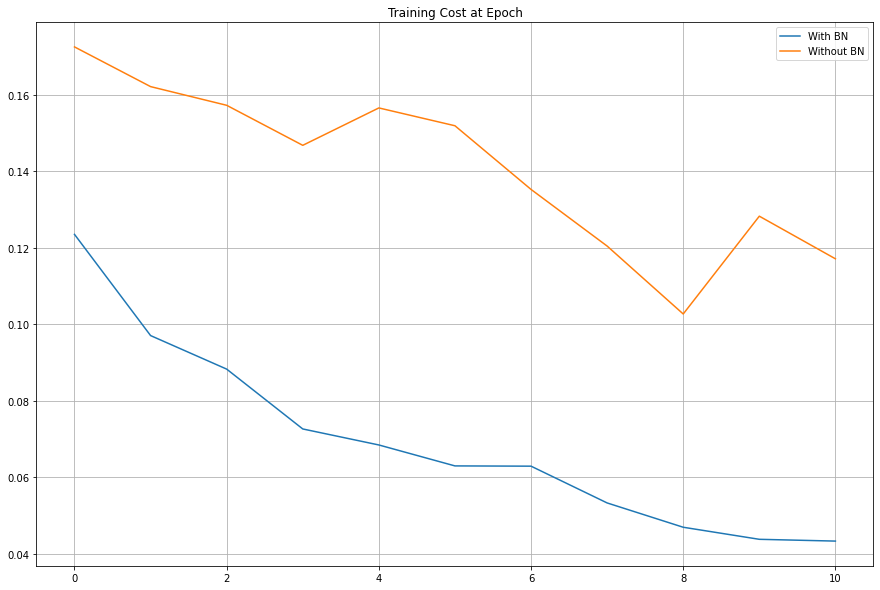

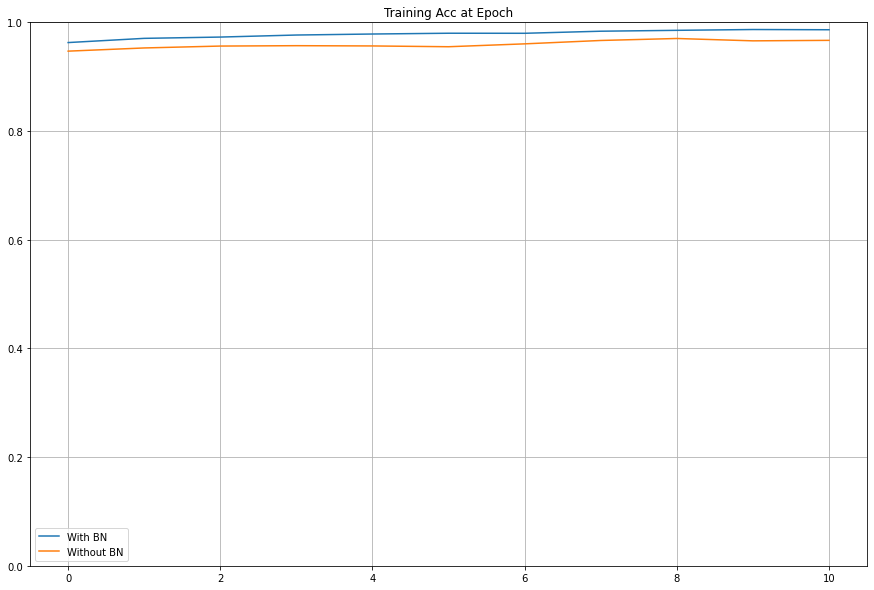

In [23]:
plot_compare(train_cost, title='Training Cost at Epoch')
plot_compare(train_acc, [0, 1.0], title='Training Acc at Epoch')